# Mermaid Man and Barnacle Boy

*A Nitrous/IPA Gas-generator driven turbopump project*

Author: Elias Aoubala

Date: 01/12/2024

In [396]:
import numpy as np
import handcalcs.render
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
from rocketcea.cea_obj_w_units import CEA_Obj

## 1 - Background

This python notebook outlines all the calculations done by the author in the sizing of the turbine and gas generator stages of the turbopump

## 2 - Combustion Requirements

It is intended that a Nitrous/IPA combination will be used for the gas generator of the gas

In [397]:
%%render

fuel = "Isopropanol"

ox = "N2O"


<IPython.core.display.Latex object>

In [398]:

cea = CEA_Obj(
    oxName=ox,
    fuelName=fuel,
    pressure_units="Bar",
    temperature_units="K",
    density_units="kg/m^3",
    specific_heat_units="J/kg-K",
)

Based on these requirements, we can start to size the turbine and gas generator accordingly.

## 3 - MR Selection

One of the first steps that needs to be conducted in the sizing of the two components is to decided what the mixture ratio of the gas generator is. This is mainly driven on material requirements, with a maximum combustion gas temperature being acceptable.

In this case,  we have opted for a maxium gas temperature of the gas generator to be around **800 K**.

We can assume the following chamber conditions for the gas generator

In [399]:
P_array = np.linspace(5, 25, 4)

O_F_array = np.arange(0.25, 3 + 0.25, 0.25)

T_add_array = np.zeros((O_F_array.size, P_array.size))

i = 0
for o_f in O_F_array:
    
    k= 0
    for P in P_array:

        T_add = cea.get_Temperatures(Pc=P, MR=o_f)[0]
    
        T_add_array[i, k]  = T_add
    
        k += 1
        
    i += 1

0
1
2
3


Text(0.5, 1.0, 'Variation of Combustion Temperature with MR')

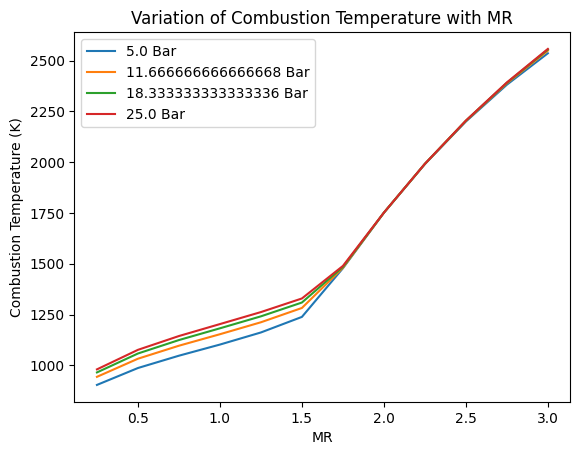

In [400]:
i = 0
for row in P_array:
    print(i)
    plt.plot(O_F_array, T_add_array[:, i], label = f"{row} Bar")
    
    i += 1
plt.legend()
plt.xlabel("MR")
plt.ylabel("Combustion Temperature (K)")
plt.title("Variation of Combustion Temperature with MR")

As can be seen, the combustion temperatures are significantly higher than we can plausibly accept for any reasonable MR. We must however consider the injector performance, as this normally has second order impacts on the combustion temperature.

c* is defined as the following:

$c^* = \frac{P_c A_t}{\dot{m}}$

We can derive the relationship between c* and the gas temperature to be as follows:

$c^* = \sqrt{\frac{T R}{\gamma} \left( \frac{\gamma + 1}{2} \right) ^{\frac{\gamma + 1}{\gamma -1 }})}$

We can assume thay any efficiency impact has negligible impact to the specific heat ratio of the specific gas constant of the resultant mixture, but only with the combustion temperature. Hence we can derive the following relationship for the $c^*$ efficiency with combustion temperature

$\eta_{c^*} = \frac{c^*_{act}}{c^*_{theo}} = \frac{\sqrt{T_{act}}}{\sqrt{T_{theo}}}$

Thus we can derive the actual combustion temperature as follows:

$T_{act} = T_{theo} \eta_{c^*}^2$

It should be noted that the assumption made that gas composition and specific heat ratio remain constant are unverified and can be gross, but it can be proximate for first pass sizing. The following c* efficiency has been assumed

In [401]:
%%render

eta_c = 0.85

<IPython.core.display.Latex object>

Based on this c* efficiency, we can now back calculate what our new combustion temperatures will be for the gas generators:

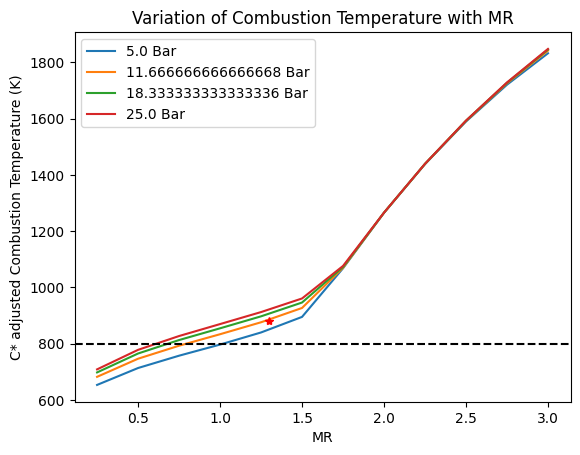

In [402]:
i = 0
for row in P_array:
    plt.plot(O_F_array, T_add_array[:, i] * eta_c**2, label = f"{row} Bar")
    
    i += 1

plt.legend()
plt.xlabel("MR")
plt.ylabel("C* adjusted Combustion Temperature (K)")
plt.title("Variation of Combustion Temperature with MR")
plt.axhline(800, linestyle="--", color="k")
plt.plot(1.3,880, marker="*", color="r")

Another quite improtant parameter to consider is the specific heat capacity of the gas, this will have critical implications on the required mass flow rate needed for the gas generator.

In [403]:
P_array = np.linspace(5, 25, 5)

O_F_array = np.linspace(0.05, 2.25, 50)

cp_add_array = np.zeros((O_F_array.size, P_array.size))

T_add_array = np.zeros((O_F_array.size, P_array.size))

i = 0
for o_f in O_F_array:
    
    k= 0
    for P in P_array:

        Cp_add = cea.get_Chamber_Cp(Pc=P, MR=o_f)
    
        cp_add_array[i, k]  = Cp_add
        
        T_add = cea.get_Temperatures(Pc=P, MR=o_f)[0]
    
        T_add_array[i, k]  = T_add
    
        k += 1
        
    i += 1

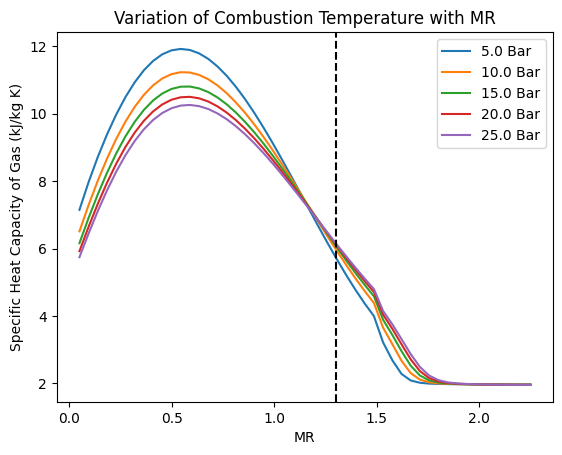

In [404]:
i = 0
for row in P_array:
    plt.plot(O_F_array, cp_add_array[:, i]/1e3, label = f"{row} Bar")
    
    i += 1

plt.legend()
plt.xlabel("MR")
plt.ylabel("Specific Heat Capacity of Gas (kJ/kg K)")
plt.title("Variation of Combustion Temperature with MR")
plt.axvline(1.3, linestyle="--", color="k")

We cann create a composite plot to further illustrate the performance expected by the turbine:

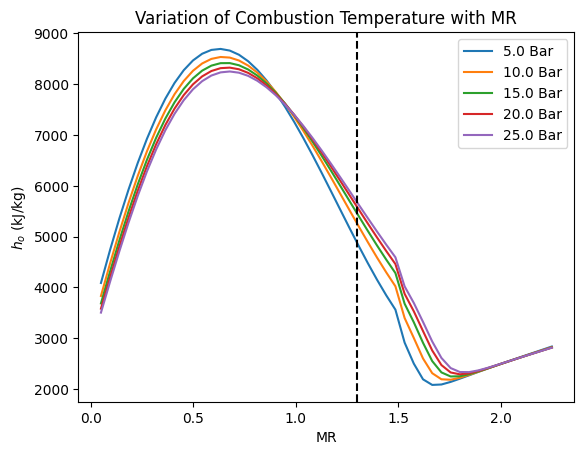

In [405]:
i = 0
for row in P_array:
    plt.plot(O_F_array, cp_add_array[:, i]/1e3 * T_add_array[:, i]  * eta_c**2, label = f"{row} Bar")
    
    i += 1

plt.legend()
plt.xlabel("MR")
plt.ylabel(r"$h_o$ (kJ/kg)")
plt.title("Variation of Combustion Temperature with MR")
plt.plot()
plt.axvline(1.3, linestyle="--", color="k")

Based on the above chart, we can base line an O/F of approximately 1.3 for the gas generator.

Now that we know our target set point, we can start to size our turbine wheel and figure out how big a gas generator we actually need to hit the performance metrics needed for the pump.

The additional observation we make is that the pressure has a minor impact on the combustion temperature conditions between 5 and 10 bar.

The baseline aim is to operate at a inlet pressure of approximately 25 bar, hence it would be advanatageous to have a combustion chamber pressure higher.

In addition, this would allow for throttling down to be more feasible, particular at startup.

A summary of the target combustion conditions for the inlet of the gas generator has been provided below:

In [406]:
%%render

P_ch = 20 # Bar

MR = 0.75

eta_c = 0.85



<IPython.core.display.Latex object>

## 4 - Power Requirement Definition

Based on the pump side liquid side, we have been provided the following power requirements:



In [407]:
%%render

N = 15000 # rpm

P_liq = 6.341 # kW


<IPython.core.display.Latex object>

This power requirement is for what is needed to be delivered to pump alone, and discounts any mechanical losses from the transmission.

This section aims to evaluate what these losses will be at our given power requirement, to account for in the turbine design.

### 4.1 - Mechanical Losses

Based on a brief analysis conducted by the author on the expected mechanical losses caused by the use of the two bearings, the following has been found:

- Mechanical Losses per bearing are estimated at approximately 200 W per bearing.

Thus, as we expect to use two bearings, we can make the following estimation that for a two bearing turbopump:

- 500 W will be used in mechanical transmission

In addition, we include an additional 1 kW contingency budget for unforeseen losses

Based on this, we can refine our power requirement for the turbopump to as follows:

In [478]:
%%render

P = P_liq + 0.5 + 1.5

<IPython.core.display.Latex object>

## 4 - Turbine Sizing

For the Turbine Sizing, we can assume Ideal gas effects for figuring out how much we will need to expand the gas.

The following equation for the specific energy release will be used:

$w = \eta_t \Delta h$

We can employ the ideal gas assumption to further expand this parameter to the following:

$w = \eta_t C_p (T_1 - T_{2s})$

We can further figure out what our isentropic expansion pressure would be accordingly using the following:

$\frac{P_2}{P_1} = \left(  \frac{T_{2s}}{T_1} \right) ^\frac{\gamma}{\gamma - 1}$

where $T_{2s}$ refers to the isentropic expansion temperature.

For the turbine stage efficiency, the following assumptions can be made:

In [479]:
%%render param

eta_t = 0.05 # Efficiency

<IPython.core.display.Latex object>

Based on this we can get an idea of what the required mass flow rates we would need for a given delta in temperature, from which we can see what the turbine expansion pressures needed to be

In [480]:
%%render param
O_F = MR

P_ch = P_ch # Bar

eta_c = eta_c

T_inlet = cea.get_Temperatures(Pc=P_ch, MR=MR )[0] * eta_c**2 # K

gamma = cea.get_Chamber_MolWt_gamma(Pc=P_ch, MR=MR )[1]

cp = cea.get_Chamber_Cp(Pc=P_ch, MR=MR ) # J/kg K


<IPython.core.display.Latex object>

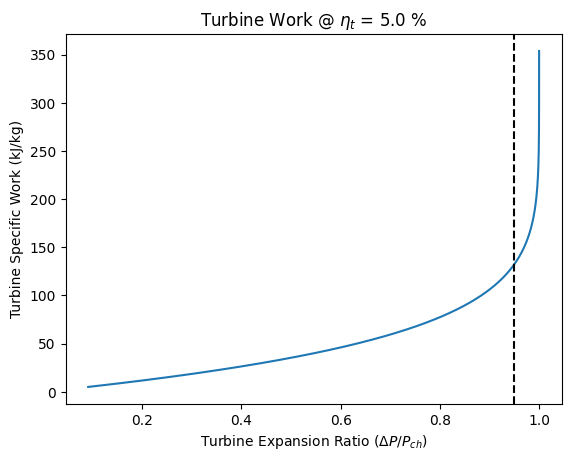

In [481]:
# We need to span different expansion temperatures to see what we


delta_T = np.linspace(10, 700, 300)

T_2s = T_inlet - delta_T

P_expand = P_ch*(T_2s/T_inlet)**(gamma/(gamma - 1))

w = cp * eta_t * delta_T

plt.plot((P_ch-P_expand)/P_ch, w/1e3)
plt.xlabel("Turbine Expansion Ratio ($\Delta P/ P_{ch}$)")
plt.ylabel("Turbine Specific Work (kJ/kg)")
plt.title(f"Turbine Work @ $\eta_t$ = {eta_t*100:.1f} %")
plt.axvline((P_ch-1)/P_ch, linestyle="--", color="k")

A dashed line has been put on where chamber pressure is assumed to expand directly to ambient pressure at 1 bar.

In [482]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Power requirement = 8341.000000000002 W


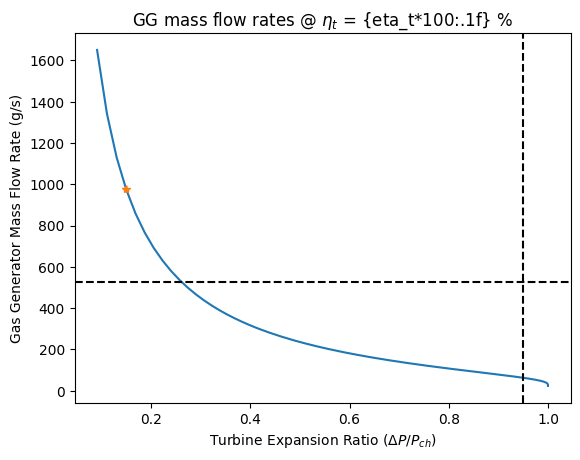

In [483]:
# We need to span different expansion temperatures to see what we

print(f"Power requirement = {P*1e3} W")

m_dot = P*1e3 / w

plt.plot((P_ch-P_expand)/P_ch, m_dot*1e3)
plt.xlabel("Turbine Expansion Ratio ($\Delta P/ P_{ch}$)")
plt.ylabel("Gas Generator Mass Flow Rate (g/s)")
plt.title("GG mass flow rates @ $\eta_t$ = {eta_t*100:.1f} %")
plt.axvline((P_ch-1)/P_ch, linestyle="--", color="k")

m_dot_max = (300)*(1+MR)

plt.axhline(m_dot_max, linestyle="--", color="k")

# Design Point
p_rat = 0.15

idx = find_nearest((P_ch-P_expand)/P_ch, p_rat)

plt.plot(((P_ch-P_expand)/P_ch)[idx], m_dot[idx]*1e3, "*")



Power requirement = 8341.000000000002 W


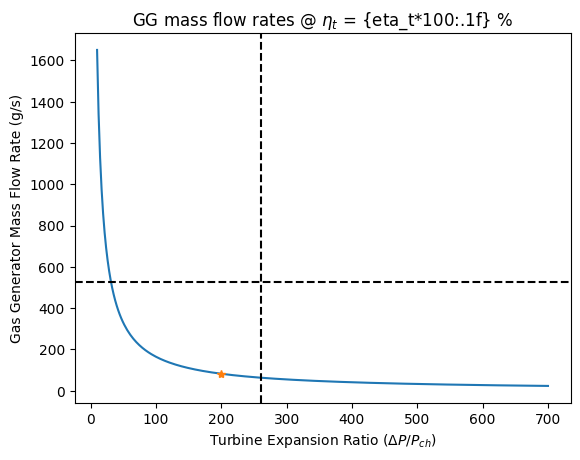

In [484]:
# We need to span different expansion temperatures to see what we

print(f"Power requirement = {P*1e3} W")

m_dot = P*1e3 / w

plt.plot(delta_T, m_dot*1e3)
plt.xlabel("Turbine Expansion Ratio ($\Delta P/ P_{ch}$)")
plt.ylabel("Gas Generator Mass Flow Rate (g/s)")
plt.title("GG mass flow rates @ $\eta_t$ = {eta_t*100:.1f} %")

idx = find_nearest((P_ch-P_expand)/P_ch, (P_ch-1)/P_ch)


plt.axvline(delta_T[idx], linestyle="--", color="k")

m_dot_max = (300)*(1+MR)

plt.axhline(m_dot_max, linestyle="--", color="k")

# Design Point
dt = 200

idx = find_nearest(delta_T, dt)

plt.plot(delta_T[idx], m_dot[idx]*1e3, "*")



Bounding lines have been provided for available mass flow rate that can be provided to the gas generator, along with the maximum turbine expansion ratio across the turbine.

**Mass flow Constraint**

The mass flow constraint has been specified based on the intended design pumping mass flow rate of 0.5 kg/s. The nominal engine design intends to use appoximately 0.22 kg/s and thus we can figurout what the maximum gas generator mass flow rate is based on the following:

$\dot{m}_{gg} = m_{f gg} (1 + MR)$

**Pressure Constraint**

The pressure contraint on the expansion across the turbine has been defined assuming a maximum feesible expansion to atmospher, which has been approximated as 1 bar.


**Comments**

Based on this graph, we can see that as out turbine expansion ratio increases, the gas generator mass flow rate progressively gets smaller inorder to provide the required power output needed for the turbine performance.

It is thus advantageous to pick a design point which is reasonably small to allow for maximum gas expansion across the turbine accordingly.

One factor that needs to be considered is what the turbopump startup performance will be during spin up, as this will be a dictating measure in deciding how much expansion is considered acceptable across the turbine. 

TODO: Solve for off nominal performance at startup to see if bootstraping of the turbine is feasible.

**Preliminary Decision**

The turbine will have a 50% expansion across it.

Thus the turbine and gas generator requirements are now the following:

In [485]:
%%render params sci_not

m_dot_gg = m_dot[idx] # kg/s

T_inlet = T_inlet # K

T_exit_s = T_2s[idx] # K

T_exit_a = T_inlet - eta_t*(T_inlet - T_exit_s) # K

P_exit = P_expand[idx] # Pa

P_act = P/eta_t

<IPython.core.display.Latex object>

## 5 - Gas-generator Design

We can now continue onto the gas generator design, focusing primarily on the strategy for our injection and ignition.

The high-level specifications of the system are the following:

In [486]:
%%render sci_not

m_dot_tot = m_dot_gg # kg/s

P_o = 50 # Bar

P_f = 44 # Bar

O_F = 0.75

Oxidiser = "Nitrous"

Fuel = "IPA"

<IPython.core.display.Latex object>

### 5.1 - Injector Design

We can start of with out injector design for the gas generator.

#### 5.1.1 - Fuel Injection

For fuel injection, we will target the following injection parameters:

In [487]:
%%render sci_not

rho_f = 786 # kg/m**3

Cd_f = 0.45

delta_pf = (P_f - P_ch)*1e5 # Pa

m_f = m_dot_gg/(O_F + 1) # kg/s

A_f = m_f / (Cd_f * (2 * rho_f * delta_pf)**(1/2)) # m**2

<IPython.core.display.Latex object>

#### 5.1.2 - Oxidiser Injection

For Oxidiser injection, we will target the following injection parameters:

In [418]:
%%render sci_not

rho_o = CP.PropsSI("D", "P", P_o*1e5, "Q", 0, "NitrousOxide") # kg/m**3

Cd_o = 0.5

delta_po = (P_o - P_ch)*1e5 # Pa

m_o = O_F*m_dot_gg/(O_F + 1) # kg/s

A_o = m_o / (Cd_o * (2 * rho_o * delta_po)**(1/2)) # m**2

<IPython.core.display.Latex object>

#### 5.2 - Injection Pattern

Given the extremely small flow rates, we will design our injector to be a coaxial injector.

We will aim for a fuel centered injector, as we can manipulate the areas to meet the COTS requirements.

The Hyperdermic needle we want are the following:

https://www.adhesivedispensing.co.uk/stainless-steel-19g-tube-110mm-od-sst19-4117-p.asp


OD: 1.1 mm

ID: 0.7 mm

The propellent that should be centered, should be the one with the lower injection area, as it allows for a larger annulus to be implemented with easier tolerances to hit.

However, given the stock needle requirements, we will likely have to opt with an alternative solution.

We can figure out how many elements we need accordingly.

In [419]:
%%render sci_not

D_orif = 0.7e-3 # m

A_orif = np.pi * (D_orif/2)**2

N = A_o / A_orif


<IPython.core.display.Latex object>

If we use the fuel as the centeric element with these type of needles, we can see that the mass flow roughly works out the 4 needles. For it to exactly hit 5 needle ID it will likely need to be a higher 

From here we can figure out how big our anulus gaps will need to be

In [420]:
%%render sci_not

N = 3

D_ext = 1.1e-3 # m

A_f_anulus =  A_f/N

A_inner = np.pi * (D_ext/2)**2

A_outer = A_f_anulus + A_inner

D_outer = (A_outer/np.pi)**(1/2) * 2 * 1e3 # mm

<IPython.core.display.Latex object>

We can approximate this to be 1.2 mm.

Thus the overall specifications for the injector are the following:

- Ox Centered Coaxial Injector

- 3 Elements

- 1.1 mm OD 0.7 mm ID hypodermic needles

- 1.4 mm anulus diameter

## 6 - Turbine Design

As we have done the basics for the turbine and gas generator specifications, we can now do some simple mean line design for the turbine.

The target for this design is an impulse design, with a degree of reaction of zero (all expansion occurs in the stator stage of the turbine).

We need to now do the mean line design of the turbine.

### 6.1 - Mean-Line Design of the Turbine

For defining the power requirement of the turbine, we can firstly start from the impulse turbine equation.

$P = \omega \dot{m} ( r_1 c_{\theta 1} - r_2 c_{\theta 2})$

Where $c_{\theta 1}$ refers to the absolute whirl velocity at the entrance of the turbine and $c_{\theta 2})$ refers to the absolute whirl velocity at the exit of the turbine.

Based on the velocity triangle, we can replace these absolute terms instead with relative whirl velocities

$c_{\theta 1} = v_{\theta 1} + U_1$

$c_{\theta 2} = v_{\theta 1} + U_2$

The following can be derived:

$P = \omega \dot{m} ( r_1 (v_{\theta 1} + U_1) - r_2 (v_{\theta 2} + U_2)))$

We can expand out the blade velocity terms in the form of the mean line blade radius and rotational speed once again to get the following:

$P = \omega \dot{m} ( r_1 (v_{\theta 1} + r_1 \omega) - r_2 (v_{\theta 2} + r_2 \omega)))$

Expanding out, we can get the following expression:

$P = \omega \dot{m} ( \omega r_1^2 + r_1 v_{\theta 1} - \omega r_2^2 - r_2 v_{\theta 2} )$

we can make the proximate assumption that the radius is equal along the mean line flow path of the turbine, this will be certainly true for an axial turbine, and is approximately true for a cantilevered solution.

In which case, we can eliminare the remaining terms to get the following:

$P = \omega \dot{m} r (v_{\theta 1} - v_{\theta 2} )$

Simplifying the expression again for the blade velocity ($\omega r = U$)

$P = \dot{m} U (v_{\theta 1} - v_{\theta 2} )$

We can now employ the velocity triangles to get this interms of the relative velocity of the gas.

$P = \dot{m} U (v_1 \cos{\beta_1} - v_2 \cos{\beta_2} )$

For an impulse turbine, $\beta_1 = - \beta_2$, and assuming that the axial velocity remains constant, the absolute velocities must by definition also remain constant.

We can thus further simplify the expression as follows:

$P = 2 [\dot{m} U v_1\cos{\beta_m}]$

Thus we come to our final expression for the power production of the turbine.

We already know what the power and mass flow rate of the gas is, the last remaining parameters that must be solved for are the blade velocity, stator exit velocity and blade angles.

To make this clear, we can write the following:

$\frac{P}{2 \dot{m}} = U v_1\cos{\beta_m}$

Based on theoretircal studies, we can describe turbine performance as being dependent on the stage velocity ratio (blade speed devided by injection velocity)

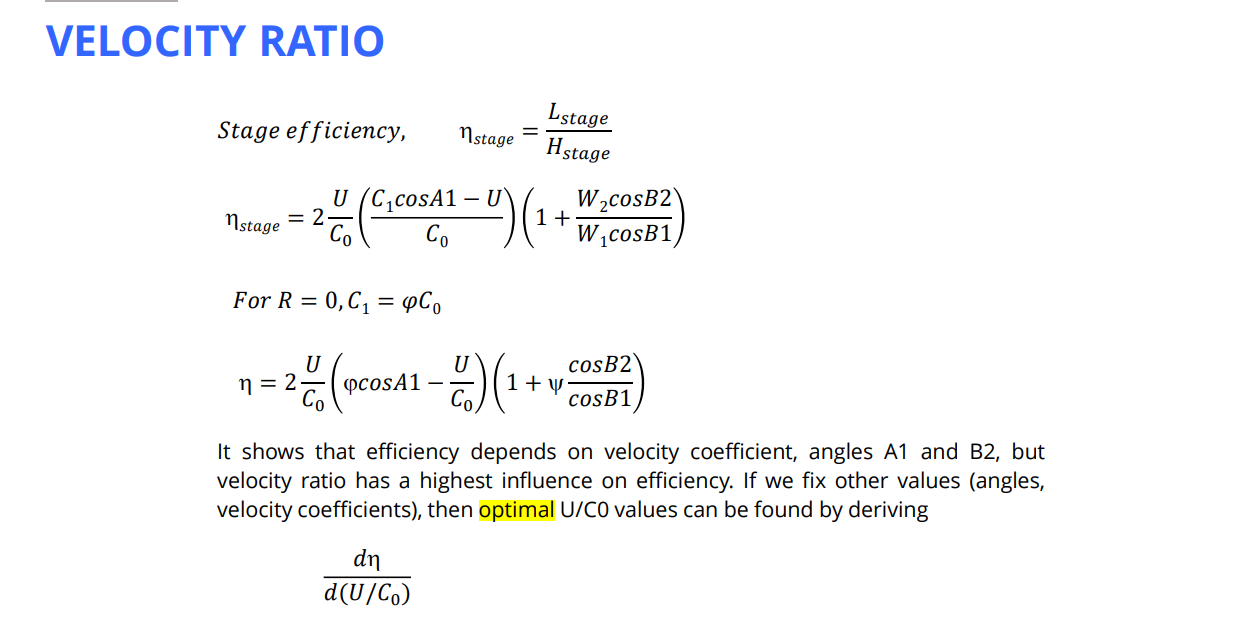

From this, we can figure out what the optimal velocity ratio would be for a pure impulse turbine:

$\left( \frac{U}{C_1} \right )_{opt} = 0.5 \phi \cos{\alpha_1}$

Where $\phi$ refers to the nozzle velocity ratio and is a performance metric describing the turbine blade performance, which typically sits around 0.95

This parameter mainly depends on the exit mach number of the turbine stage.

A regression based on experimental data has been conducted here for supersonic turbine blades: [link](https://www.orc2019.com/online/proceedings/documents/9.pdf)

Based on the above expression, we can substitue the value for the blade speed into the power equation to get the following:

$\frac{P}{2 \dot{m}} = 0.5 C_1 v_1 \phi \cos{\alpha_1} \cos{\beta_m}$

Simplifying:

$\frac{P}{\dot{m}} = C_1 v_1 \phi \cos{\alpha_1} \cos{\beta_m}$

Substituting an approximate value for the blade velocity, we get the following:

$\frac{P}{\dot{m}} = 0.95 [C_1 v_1 \cos{\alpha_1} \cos{\beta_m}]$

As for an impulse turbine, all the expansion occurs in the nozzle, thus making C_1 known by definition:

$C_1 = \sqrt{2 * \Delta h}$

Thus we can further re-arrange the parameters to the following:

$\frac{P}{\dot{m} \sqrt{2 * \Delta h}} = 0.95 [v_1 \cos{\alpha_1} \cos{\beta_m}]$

Finally, we can decompose the definition of V_1 interms of alpha_1 easily

$V_1 = \sqrt{C_a^2 + V_{\theta 1}^2}$

$V_1 = \sqrt{C_a^2 + (C_{\theta 1} - U_1)^2}$

$V_1 = \sqrt{(C_1 \sin{\alpha_1})^2 + (C_1 \cos{\alpha_1} - U_1)^2}$

$V_1 = C_1\sqrt{(\sin{\alpha_1})^2 + (\cos{\alpha_1} - \frac{U_1}{C_1})^2}$

$V_1 = C_1\sqrt{(\sin{\alpha_1})^2 + (\cos{\alpha_1} - \frac{\phi \cos{\alpha_1}}{2})^2}$


$\frac{P}{2 [\dot{m} \Delta h]} = \phi [\sqrt{(\sin{\alpha_1})^2 + (\cos{\alpha_1} - \frac{\phi \cos{\alpha_1}}{2})^2} \cos{\alpha_1} \cos{\beta_m}]$

Using the thermodynamic definition of the power produced from a turbine stage, we can finally simplify the relation as follows

$P = \dot{m} \Delta h$

$\frac{1}{2} = [\sqrt{(\sin{\alpha_1})^2 + (\cos{\alpha_1} - \frac{\phi \cos{\alpha_1}}{2})^2} \cos{\alpha_1} \cos{\beta_m}]$

$\frac{1}{2\phi} = [\sqrt{(\sin{\alpha_1})^2 + (\cos{\alpha_1} - \frac{\phi \cos{\alpha_1}}{2})^2} \cos{\alpha_1} \cos{\beta_m}]$

Based on this, we can see that their is only two parameters for us there are three parameters for us to play with:

- \alpha_1: Blade injection angle
- \beta_m: Blade metal Angles

From this, we can make a basic performance plot to see how each parameter varies with each other


### Stage Efficiency derivation

For a reaction turbine, we can describe the stage efficiency as the following:

$\eta_{stage} = \frac{L_{stage}}{H_{stage}}$

Where L_{stage} refers to the work pulled out of the turbine stage, and H_stage refers to the theoretical enthalpy drop required for the turbine.

We can expand the actual work performed by the stage by using the actual flow angles fo the turbine to get the following:

$\eta_{stage} = \frac{U(V_{\theta 1} + V_{\theta 2})}{H_{stage}}$

We can introduce the concept of the theoretical sprouting velocity, which is the equivalent velocity atained by a gas through the a kinetic expansion in the stator.

$C_o = \sqrt{2 H_{stage}}$

Hence we can re-write this expression as follows:

$\eta_{stage} = \frac{2U(V_{\theta 1} + V_{\theta 2})}{C_o^2}$

We can now factor out $V_{\theta 1}$ and re-arrange the following:

$\eta_{stage} = 2 \frac{U}{C_o} \left( \frac{V_{\theta 1}}{C_o} \right) \left( 1 + \frac{V_{2 \theta}}{V_{1 \theta}} \right)$

We can now employ our velocity triangles

$\eta_{stage} = 2 \frac{U}{C_o} \left( \frac{V_{\theta 1}}{C_o} \right) \left( 1 + \frac{W_2 \cos{\beta_2}}{W_1 \cos{\beta_1}} \right)$

$\eta_{stage} = 2 \frac{U}{C_o} \left( \frac{C_1 \cos{\alpha_1} - U}{C_o} \right) \left( 1 + \frac{W_2 \cos{\beta_2}}{W_1 \cos{\beta_1}} \right)$

Finally we can simplify this expression to the following:

$\eta_{stage} = 2 \frac{U}{C_o} \left( \frac{C_1}{C_o} \cos{\alpha_1} - \frac{U}{C_o} \right) \left( 1 + \frac{W_2 \cos{\beta_2}}{W_1 \cos{\beta_1}} \right)$

We can now define two non-dimensional parameters describing the nozzle and blade performance, being the following:

$\phi = \frac{C_1}{C_o}$

$\psi = \frac{W_2}{W_1}$

$\eta_{stage} = 2 \frac{U}{C_o} \left( \phi \cos{\alpha_1} - \frac{U}{C_o} \right) \left( 1 + \psi\frac{\cos{\beta_2}}{\cos{\beta_1}} \right)$

Finally if we assume symmetric blading, where $\beta_1 = \beta_2$, we can simplify this entire expression to the following:

$\eta_{stage} = 2 \frac{U}{C_o} \left( \phi \cos{\alpha_1} - \frac{U}{C_o} \right) \left( 1 + \psi \right)$

From here, we can rearrange the terms here:

$A = \frac{U}{C_o}$

$\eta_{stage} = 2 A \phi (\cos{\alpha_1} + \cos{\alpha_1} \psi) - 2 A^2 ( 1 + \psi)$


### Turbine Performance Plots

We can now create a set of plots characterising system efficiency as a function of the stage flow coefficient (\frac{U}{C_o}).

The methodolody is the following:

1. C_o is already defined as the enthalpy drop desired across the stage is already defined.
2. We can calulate \phi as it is only dependent on the mach number of the isentropic mach number of the gas, which can be calculated from phi.
3. Hence there are only two remaining parameters, namely U and alpha.
4. You can calculate your deflection angle and relative mach number from these two parameters, from which you thus calculate psi.
5. You thus make a 3D plot fo turbine stage performance vs blade speed and inlet angle for your given set point.

### Inputs

In [517]:
# We define our alpha array 

i = 100

alpha_arr = np.linspace(45,70,i)*np.pi/180 # rad

# We define our blade velocity array

k = 100

U_org = np.linspace(100,400,k) # m/s

# We need to now tile and repeat the arrays accordingly.

alpha_arr, U = np.meshgrid(alpha_arr, U_org)

# We define our temperature drop we wish to aim for (isentropically)

dt = T_inlet - T_exit_s # K

print(dt)

# We also define our RPM

N = 20000

199.23076923076917


In [518]:
def nozzle_phi(Ma1):
    
    phi2 = (
            1
            - (0.0029 * Ma1**3 - 0.0502 * Ma1**2 + 0.2241 * Ma1 - 0.0877)
        ) ** (0.5)
    
    return phi2

def blade_phi(deltaB, Ma1_rel):
    
    phi3 = (
            0.957
            - 0.000362 * deltaB
            - 0.0258 * Ma1_rel
            + 0.00000639 * deltaB**2
            + 0.0674 * Ma1_rel**2
            - 0.0000000753 * deltaB**3
            - 0.043 * Ma1_rel**3
            - 0.000238 * deltaB * Ma1_rel
            + 0.00000145 * deltaB**2 * Ma1_rel
            + 0.0000425 * deltaB * Ma1_rel**2
        )
    
    return phi3



We evaluate for our isentropic blade velocity and mach number.

In [519]:
# Calculating the velocity

T_exit_s = T_inlet - dt

print(dt)

C_o = (2 * cp*dt)**(1/2)

R = cp*(gamma - 1)/gamma

c = np.sqrt(gamma * R * T_exit_s)

P_2 = P_ch * 1e5 * ((T_exit_s/T_inlet)**(gamma / (gamma - 1)))

rho_exit = P_2/(R*T_exit_s)

print(rho_exit)

M_1s = C_o/c

print(M_1s)
print(phi)

199.23076923076917
0.28436557896693687
2.086736335112974
0.9012799161598287


We can calulate our nozzle factor

In [520]:
# Calculating the loading coefficient

phi = nozzle_phi(M_1s)

# phi = 1

We need to now figure out what our beta angle and relative mach numbers will be based on the inlet velocities we intend to use. To do this, we need to calculate all our possible whirl velocities.

In [521]:
C_1w = C_o*phi*np.sin(alpha_arr)

V_1w = C_1w - U

C_a = C_o*phi*np.cos(alpha_arr)

V_1 = (V_1w**2 + C_a**2)**(1/2)

M_1r = V_1/c

beta_r = np.atan(V_1w/C_a)

delta_b = beta_r*2

tan_a_2 = np.tan(alpha_arr) - (2*U/C_a)

alpha_2 = np.atan(tan_a_2)

delta_a = alpha_2 + alpha_arr

# print(delta_b)
psi = blade_phi(deltaB=delta_b, Ma1_rel=M_1r)



Now that we have all our parameters, we can calculate our efficiencies.

In [522]:
eta_arr = 2 * (U/C_o) * (phi*np.sin(alpha_arr) - (U/C_o))*(1 + psi)

# print(2 * (U/C_o) * (1*np.sin(alpha_arr) - (U/C_o))*(1 + 1))

# print((2*U/C_o**2)*(V_1w*2))

print(U*(2*V_1w)/(cp*dt))

[[0.11707605 0.11763457 0.11819062 ... 0.15830315 0.15857881 0.1588512 ]
 [0.12031382 0.12088927 0.12146217 ... 0.16279023 0.16307424 0.16335489]
 [0.12353336 0.12412573 0.12471548 ... 0.16725907 0.16755144 0.16784034]
 ...
 [0.34624056 0.34844081 0.3506313  ... 0.50865036 0.5097363  0.51080934]
 [0.34770959 0.34992677 0.35213411 ... 0.5113687  0.51246299 0.51354429]
 [0.34916039 0.35139449 0.35361868 ... 0.5140688  0.51517145 0.516261  ]]


Text(0.5, 1.0, 'Turbine Profile Loss Factor @ dt = 199.2 K')

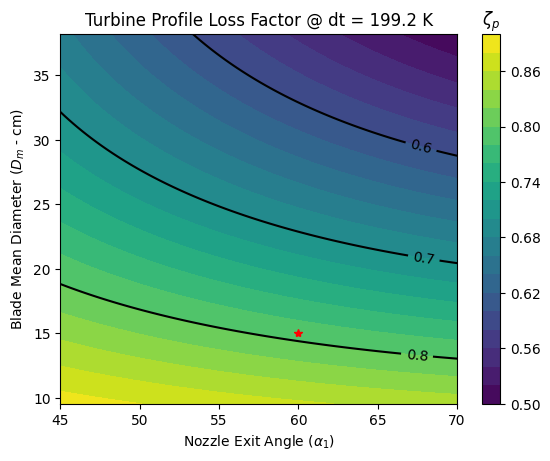

In [523]:
omega = N*(2*np.pi)/60

r = U/omega

D_m = r*2*100

fig, ax = plt.subplots()

plt.contourf(alpha_arr*180/np.pi, D_m, 1 - eta_arr, 20 )
clb = plt.colorbar()
clb.ax.set_title(r'$\zeta_p$')
CS = ax.contour(alpha_arr*180/np.pi, D_m, 1 - eta_arr, [0.4, 0.5, 0.6, 0.7, 0.8], colors="k")
ax.clabel(CS, inline=True, fontsize=10)
plt.plot(60, 15, color="r", marker="*" )

plt.xlabel(r"Nozzle Exit Angle ($\alpha_1$)")
plt.ylabel(r"Blade Mean Diameter ($D_m$ - cm)")
plt.title(f"Turbine Profile Loss Factor @ dt = {dt:.1f} K")

In [533]:
omega = N*(2*np.pi)/60

r = U/omega

D_m = r*2*100

fig, ax = plt.subplots()

plt.contourf(alpha_arr*180/np.pi, D_m, delta_b*180/np.pi, 20 )
clb = plt.colorbar()
clb.ax.set_title(r'$\Delta \beta$')
CS = ax.contour(alpha_arr*180/np.pi, D_m, delta_b*180/np.pi, [60, 70, 80, 90, 100, 110, 120], colors="k")
ax.clabel(CS, inline=True, fontsize=10)
plt.plot(60, 15, color="r", marker="*" )

plt.xlabel(r"Nozzle Exit Angle ($\alpha_1$)")
plt.ylabel(r"Blade Mean Diameter ($D_m$ - cm)")
plt.title(fr"Rotor Deflection Angle @ dt = {dt:.1f} K")

UsageError: Cell magic `%%` not found.


Now we can find the nearest point to extract the exact value for our design point

In [546]:
kdx = find_nearest(15, D_m[:,1])

fdx = find_nearest(60, (alpha_arr*180/np.pi)[1,:])

print(kdx)

print(fdx)

19
59
15.047376437779194
59.8989898989899


We can now extract our blade angle deflection

In [549]:
%%render

target_dbeta = delta_b[kdx, fdx] * 180/np.pi

target_beta = beta_r[kdx, fdx] * 180/np.pi

<IPython.core.display.Latex object>

### Ventilation Losses

With regards to Ventilation Losses, we can estimate their impact by using a similar corrolation - (these ar fritcion and ventilation/secondary losses included):

$P_v = \left( \frac{1.85}{2}\right) [ 4.5(1 - \epsilon)\rho_{exit} \left( \frac{n}{60} \right)^3 D_{m}^4 h_{b}]$

$P_v = 4.1625 [(1 - \epsilon)\rho_{exit} \left( \frac{n}{60} \right)^3 D_{m}^4 h_{b}]$

Where $\rho_{exit}$ is the exit density of the gas, $\epsilon$ is the partial admission ratio of the turbine, $D_m$ is the blade diameter, and $h_b$ is the blade height.

It has been advised in the previously referenced publication ([here](https://www.orc2019.com/online/proceedings/documents/9.pdf)) to keep the blade height to mean diameter ratio (h/D_m) between 0.025 to 0.10.

We can nondimensionalise this factor with regards to our isentropic energy we want to meet and transfrom the factor into a zeta

$\frac{P_v}{P_isen} = \zeta_v =  4.1625 [(1 - \epsilon)\rho_{exit} \left( \frac{n}{60} \right)^3 D_{m}^4 h_{b}]$

$\zeta_v =  \frac{4.1625}{\rho_{exit} A_{exit} V_{exit} (\Delta H_o)} [(1 - \epsilon)\rho_{exit} \left( \frac{n}{60} \right)^3 D_{m}^4 h_{b}]$

We can make the assumption that the velocity at the exit and entrance of the rotor are the same. In addition, as the degree of reaction is constant, we can say that the density across the rotor is constant as pressure and temperature remain constant.

$C_o = \sqrt{2 H_o}$

$\zeta_v =  \frac{8.325}{\pi D_{m} h_{b} C_o^3 } [(1 - \epsilon) \left( \frac{n}{60} \right)^3 D_{m}^4 h_{b}]$

$\zeta_v =  \frac{8.325}{\pi C_o^3 } [(1 - \epsilon) \left( \frac{n}{60} \right)^3 D_{m}^3]$

$\zeta_v =  \frac{8.325}{\pi C_o^3 } [(1 - \epsilon) \left( \frac{n  D_{m}}{60} \right)^3]$

$\zeta_v =  \frac{8.325}{\pi C_o^3 } [(1 - \epsilon) \left( \frac{U_m}{2} \right)^3]$


C_o is a fixed parameter by definition, the rotational rate of the turbine is fixed by definition, hence the last remaining parameter dependent parameters are the partial emission ratio ($\epsilon$) and the Median Diameter of the turbine.

We can create another contour plot that allows us to access the turbine performance using these two parameters once again.

In [495]:
epsilon = np.linspace(0.1,0.9, i)

epsilon , U_2 = np.meshgrid(epsilon, U_org)

omega = N *(2*np.pi)/60

r_2 = U_2/omega

D_m2 = r_2*2

zeta_v_arr = (8.325)*( (1- epsilon) * (U_2)**3)/(np.pi * C_o**3)

print(zeta_v_arr)


[[2.94932177e-04 2.92284077e-04 2.89635976e-04 ... 3.80664426e-05
  3.54183422e-05 3.27702419e-05]
 [3.22564885e-04 3.19668680e-04 3.16772474e-04 ... 4.16329538e-05
  3.87367483e-05 3.58405428e-05]
 [3.51871806e-04 3.48712463e-04 3.45553120e-04 ... 4.54155530e-05
  4.22562101e-05 3.90968673e-05]
 ...
 [1.80306089e-02 1.78687179e-02 1.77068269e-02 ... 2.32718297e-03
  2.16529198e-03 2.00340099e-03]
 [1.84499088e-02 1.82842531e-02 1.81185973e-02 ... 2.38130136e-03
  2.21564561e-03 2.04998987e-03]
 [1.88756593e-02 1.87061809e-02 1.85367025e-02 ... 2.43625233e-03
  2.26677390e-03 2.09729548e-03]]


Text(0.5, 1.0, 'Ventilation Losses for the Turbine @ dt = 199.2 K')

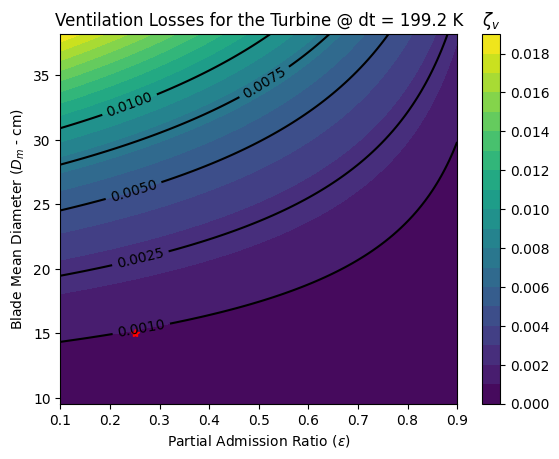

In [496]:
fig, ax = plt.subplots()

plt.contourf(epsilon, D_m2*1e2, zeta_v_arr, 20 )
clb = plt.colorbar()
clb.ax.set_title(r'$\zeta_v$')
CS = ax.contour(epsilon, D_m2*1e2, zeta_v_arr, [0.001, 0.0025, 0.005, 0.0075, 0.01], colors="k")
ax.clabel(CS, inline=True, fontsize=10)
plt.plot(0.25, 15, color="r", marker="*" )

plt.xlabel(r"Partial Admission Ratio ($\epsilon$)")
plt.ylabel(r"Blade Mean Diameter ($D_m$ - cm)")
plt.title(f"Ventilation Losses for the Turbine @ dt = {dt:.1f} K")

#### Leakage Losses

With regards to leakage Losses, we can evaluate their impact directly on efficiency by employing the relation proposed for subsonic turbines by [Beer, 1965](https://ntrs.nasa.gov/api/citations/19660004946/downloads/19660004946.pdf).

$\zeta_{lr} = K_i \frac{A_{lr}}{\omega_2 \sin{\beta_2}}$

where zeta refers to the loss factor that directly augments the velocity triangle efficiency, $A_{lr}$ is the leakage area from the tip gap, $\omega_2$ is the Anulus area of the rotor, $\beta_2$ is the relative entrance angle of the turbine.

The zeta factor is implemented into the traditional profile losse efficiency in the following manner

$\eta_u = \eta_p - \zeta_{lr}$

The K_1 factor is an imperical factor dependent on the change of absolute angle across the rotor stage .

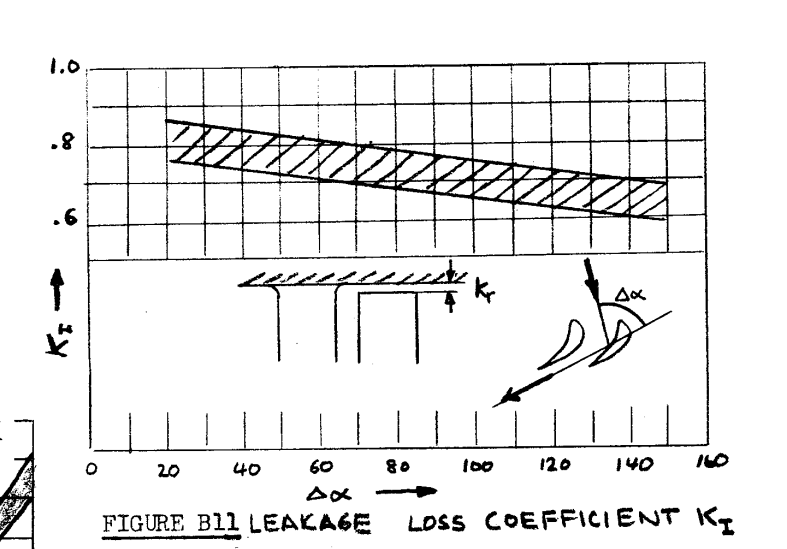

As can be seen, a bounding box is presented for which the leakage loss coefficient can be estimated, and that the relationship appears to be linear.

A simple linear regression is used here based on two points selected to describe the losee:

- (140, 0.7)
- (70, 0.8)

From this, we can derive the simple following relation:

$K_I = 0.9 - \frac{1}{700}\Delta{\alpha}  $

From here, we can implement a simple model for the calculating of the leakage losses accordingly.



In [497]:
# Defining our imperial coefficient

def k_i(del_a):
    
    k_ir = 0.9 - (1/700)*del_a
    
    return k_ir

The driving factor for the leakage gap will be the machined tolerances, and thus we can set an arbitrary leakage gap of 3 mm for this analysis. From here, we can create a performance plot describing how the diameter and blade height influences the blade performance 

In [498]:
# Defining our leakage gap
k_r = 3e-3

h_blade = 40e-3


zeta_l = (k_i(del_a=delta_a) * k_r / (D_m * np.sin(beta_r))) * (k_r/h_blade + D_m/h_blade + 1)




Text(0.5, 1.0, 'Leakage Losses for the Turbine  @ dt = 199.2 K')

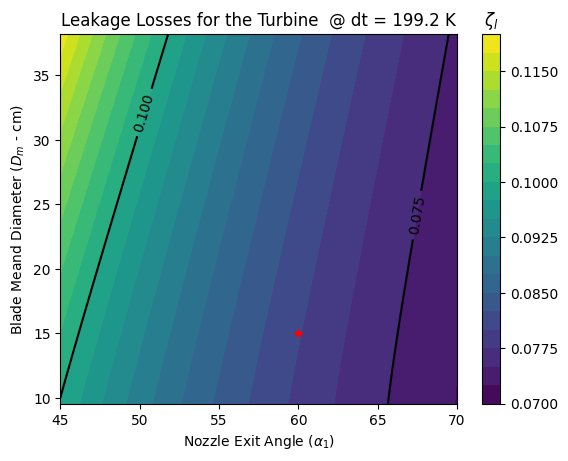

In [499]:
fig, ax = plt.subplots()

plt.contourf(alpha_arr*180/np.pi, D_m, zeta_l, 20 )
clb = plt.colorbar()
clb.ax.set_title(r'$\zeta_l$')
CS = ax.contour(alpha_arr*180/np.pi, D_m, zeta_l, [0.05, 0.075, 0.10, 0.125, 0.15, 0.175], colors="k")
ax.clabel(CS, inline=True, fontsize=10)
plt.plot(60, 15, color="r", marker="*" )


plt.xlabel(r"Nozzle Exit Angle ($\alpha_1$)")
plt.ylabel(r"Blade Meand Diameter ($D_m$ - cm)")
plt.title(f"Leakage Losses for the Turbine  @ dt = {dt:.1f} K")

We can get the performance curve for a given design point with regards to leakage:

In [500]:
alpha_1 = 60*np.pi/180 # rad

D_target = 15e-2 # m

U_target = D_target/2 * omega


In [501]:
C_1w = C_o*phi*np.sin(alpha_1)

V_1w = C_1w - U_target

C_a = C_o*phi*np.cos(alpha_1)

V_1 = (V_1w**2 + C_a**2)**(1/2)

M_1r = V_1/c

beta_r = np.atan(V_1w/C_a)

delta_b = beta_r*2

tan_a_2 = np.tan(alpha_1) - (2*U_target/C_a)

alpha_2 = np.atan(tan_a_2)

delta_a = alpha_2 + alpha_1

print(U_target)

# print(delta_b)
psi = blade_phi(deltaB=delta_b, Ma1_rel=M_1r)



157.07963267948966


In [502]:
# Defining our leakage gap
k_r = np.linspace(1,5, 100)* 1e-3

h_blade = np.linspace(5,20, 100)* 1e-3

k_r, h_blade = np.meshgrid(k_r, h_blade)

zeta_l_spec = (k_i(del_a=delta_a) * k_r / (D_target * np.sin(beta_r))) * (k_r/h_blade + D_target/h_blade + 1)

print(k_i(del_a=delta_a))


0.8971535044262092


Text(0.5, 1.0, 'Leakage Losses for the Turbine  @ dt = 199.2 K')

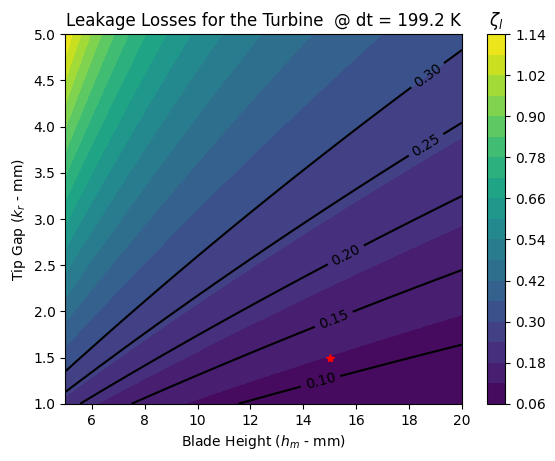

In [503]:
fig, ax = plt.subplots()

plt.contourf(h_blade*1e3, k_r*1e3, zeta_l_spec, 20 )
clb = plt.colorbar()
clb.ax.set_title(r'$\zeta_l$')
CS = ax.contour(h_blade*1e3, k_r*1e3, zeta_l_spec, [0.05, 0.10, 0.15, 0.20, 0.25, 0.3], colors="k")
ax.clabel(CS, inline=True, fontsize=10)

plt.plot(0.1*D_target*1e3, 1.5, color="r", marker="*" )

plt.xlabel(r"Blade Height ($h_m$ - mm)")
plt.ylabel(r"Tip Gap ($k_r$ - mm)")
plt.title(f"Leakage Losses for the Turbine  @ dt = {dt:.1f} K")

Text(0.5, 1.0, 'Leakage Losses for the Turbine  @ dt = 199.2 K')

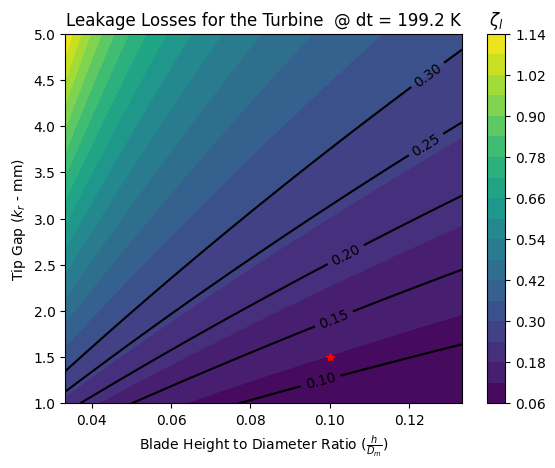

In [504]:
fig, ax = plt.subplots()

plt.contourf(h_blade/D_target, k_r*1e3, zeta_l_spec, 20 )
clb = plt.colorbar()
clb.ax.set_title(r'$\zeta_l$')
CS = ax.contour(h_blade/D_target, k_r*1e3, zeta_l_spec, [0.05, 0.10, 0.15, 0.20, 0.25, 0.3], colors="k")
ax.clabel(CS, inline=True, fontsize=10)

plt.plot(0.1, 1.5, color="r", marker="*" )

plt.xlabel(r"Blade Height to Diameter Ratio ($\frac{h}{D_m}$)")
plt.ylabel(r"Tip Gap ($k_r$ - mm)")
plt.title(f"Leakage Losses for the Turbine  @ dt = {dt:.1f} K")

NameError: name 'epsilon_arr' is not defined

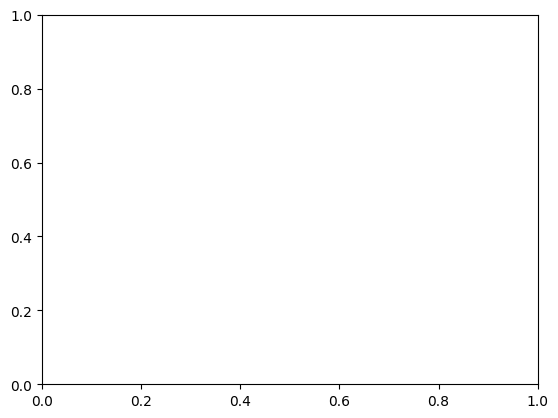

In [505]:
fig, ax = plt.subplots()

plt.contourf(h_blade*1e3, k_r*1e3, epsilon_arr, 20 )
clb = plt.colorbar()
clb.ax.set_title(r'$\zeta_l$')
# CS = ax.contour(h_blade*1e3, k_r*1e3, zeta_l_spec, [0.05, 0.10, 0.15, 0.20, 0.25, 0.3], colors="k")
ax.clabel(CS, inline=True, fontsize=10)
# plt.plot(60, 20, color="r", marker="*" )


plt.xlabel(r"Blade Height ($h_m$ - mm)")
plt.ylabel(r"Tip Gap ($k_r$ - mm)")
plt.title(f"Leakage Losses for the Turbine  @ dt = {dt:.1f} K")

### Conclusions from loss model

Three test cases have been generated for us to asses system performance accordingly. Overall stage efficiency is calculated using the following relation:

$\eta = 1 - \zeta_p - \zeta_v -\zeta_l$

Test Cases Evaluated are the following:

- dt = 250 K
- dt = 200 K
- dt = 150 K
- dt = 50 K

**DT = 150 K**

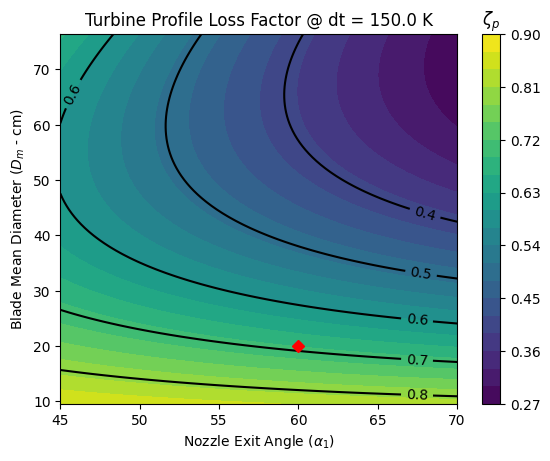 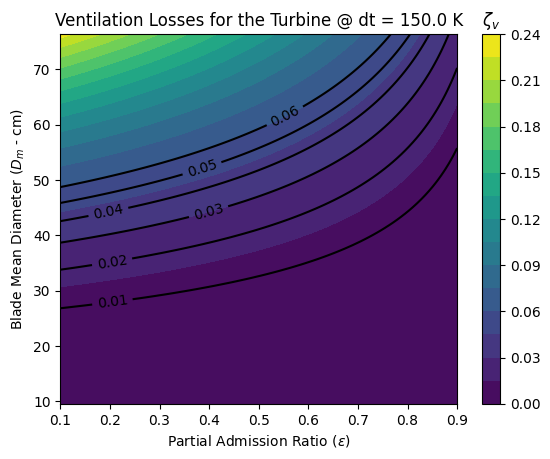 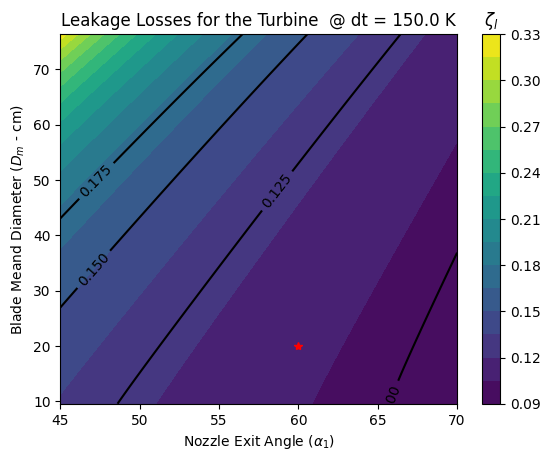

Estimated Stage Efficiency:

$\eta = 1 - 0.69 - 0.006 - 0.112 = 0.192$

Overall Specific Power:

$L = \eta C_p dt = 0.192 * 10.11 * 150 = 291.168 $ kW s/kg

**DT = 50 K**

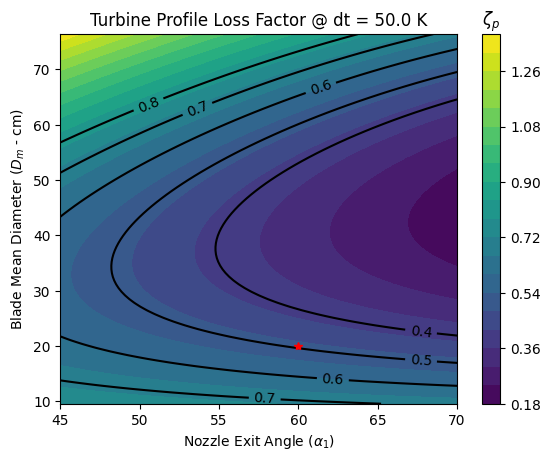 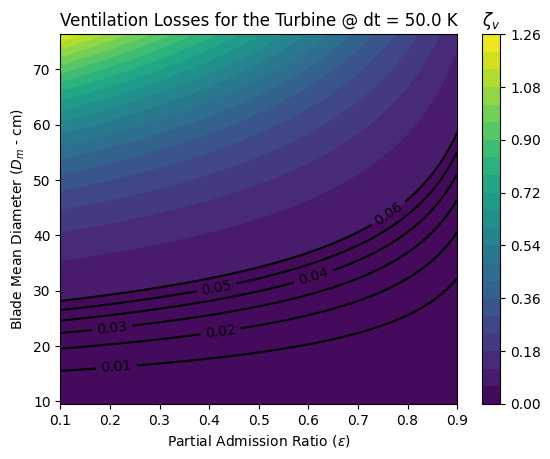 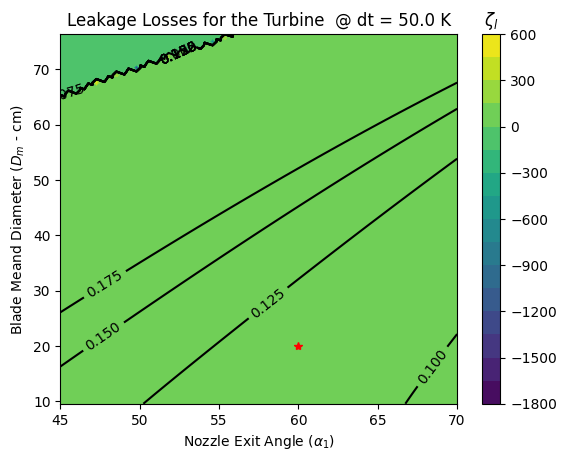

Estimated Stage Efficiency:

$\eta = 1 - 0.5 - 0.01 - 0.12 = 0.37$

Overall Specific Power:

$L = \eta C_p dt = 0.37 * 10.11 * 150 = 187.035 $ kW s/kg

**DT = 200 K**

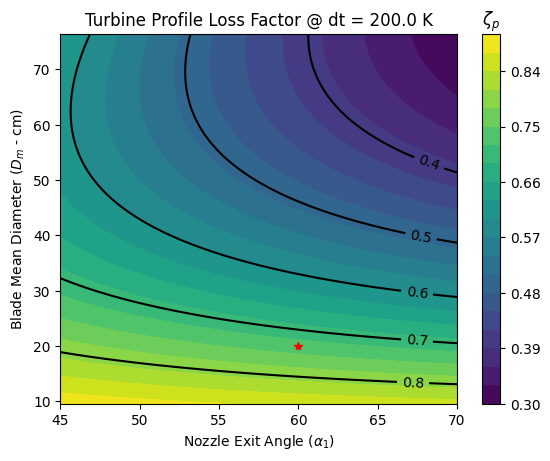 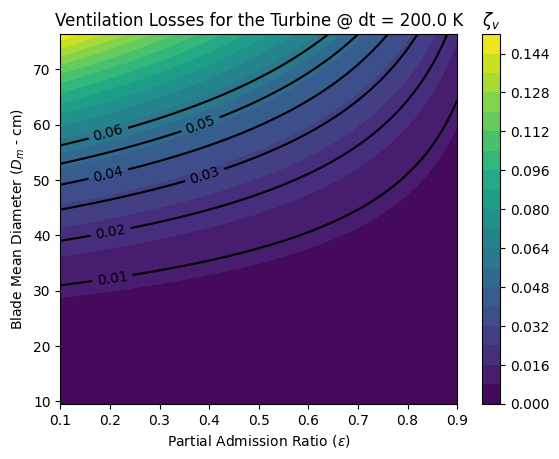 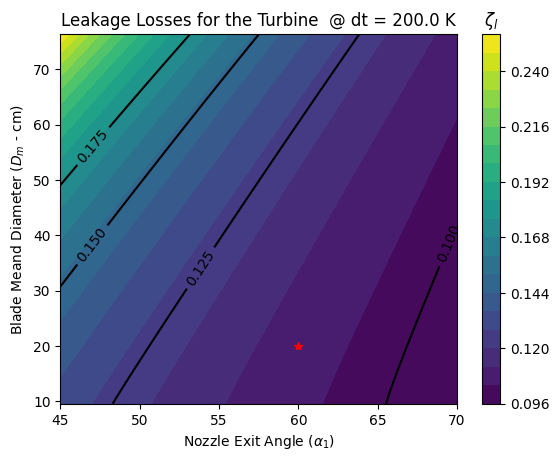

Estimated Stage Efficiency:

$\eta = 1 - 0.73 - 0.006 - 0.11 = 0.154$

Overall Specific Power:

$L = \eta C_p dt = 0.154 * 10.11 * 200 = 311.388 $ kW s/kg

**DT = 250 K**

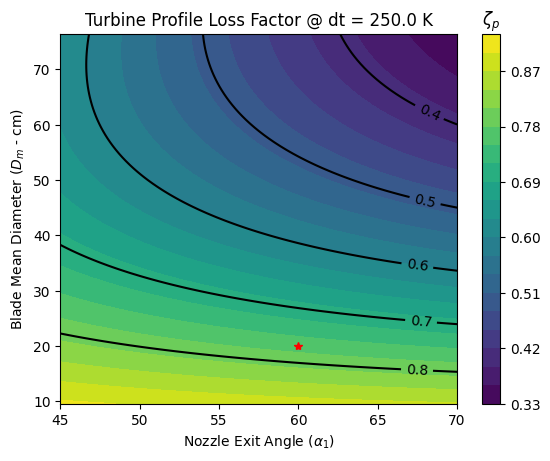 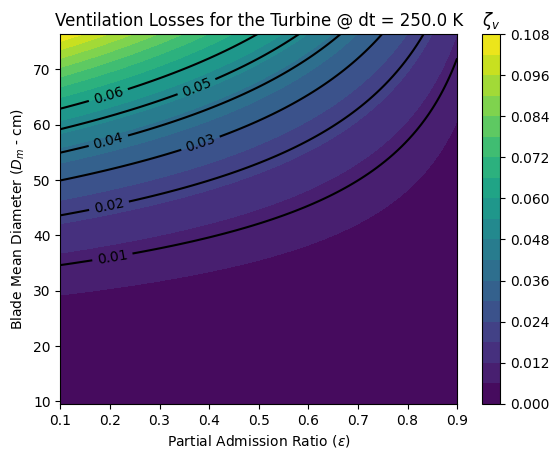 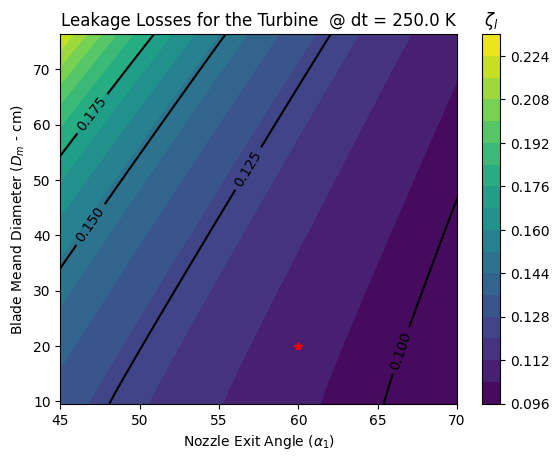

Estimated Stage Efficiency:

$\eta = 1 - 0.765 - 0.006 - 0.11 = 0.119$

Overall Specific Power:

$L = \eta C_p dt = 0.154 * 10.11 * 200 = 300.7725 $ kW s/kg

Based on the results, we can see that the stage performance peaks at a dt of 200 K for our given design point, from which we can decide our target point.

So far we are yet to pick a partial admission ratio, and thus the leakage losses have been based on a n assumed blade height. As we have observed that the windage losses are low for our blade mean diameter, we can now do a brief study investigating the impact of partial admission ratio on resultant leakage losses.

We will simply change the blade height to see how that will impact the blade losses accordingly - we will fix the blade diameter and nozzle exit angle based on the design point selected. We can then make a simple plot of blade height and tip gap to get an idea of the losses of the system.

Based on all this we can aim for an efficiency of 15.4% overall.

From this we can now figure out exactly what our mass flow rate for the turbine stage should be:

### Final Setpoint Selection

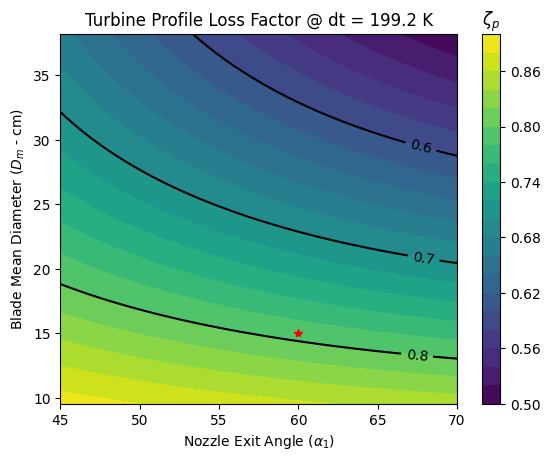 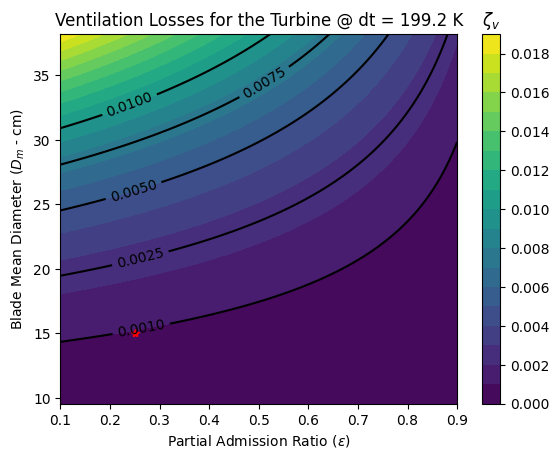 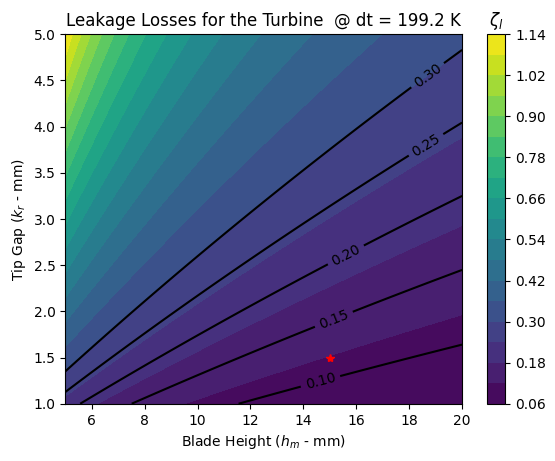 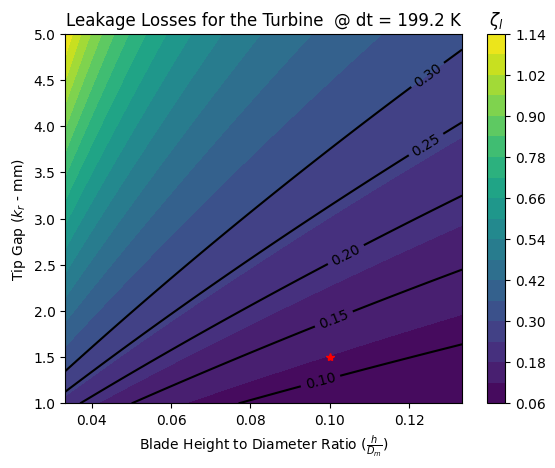

Blade Height had been selected based on literature indicating average blade height to diameter ratios on the order of 0.025 - 0.10 [link](https://www.orc2019.com/online/proceedings/documents/9.pdf) and [link](https://www.eucass.eu/doi/EUCASS2022-4928.pdf).

This results in us having the following performance metrics:

The final Selected Geometry is:

- 15 cm Blisk

- 60 degrees Nozzle Exit Angle

- 0.2 Partial Admission Ratio

- 15 mm Blade Height

- $\Delta \beta$ of 

In [473]:
%%render

zeta_p = 0.8

zeta_v = 0.001

zeta_l = 0.125

eta = 1 - zeta_p - zeta_v - zeta_l

m_dot_t = P*1e3/(eta*cp*(T_inlet - T_exit_s))

<IPython.core.display.Latex object>

## 7 - Turbine Geometry Generation

Based on our observation of the impact of partial admission losses to be minor, we can select an arbitrary partial admission ratio of 0.20 for the rotors. This allows for more than sufficient growing room for a more capable turbine stage.

In [506]:
%%render

epsilon = 0.25

<IPython.core.display.Latex object>

### 7.1 Stator Geometry

A classic R_1, R_2, R_n approach is used for the design of the turbine geometry

A 15 degree cone half angle is used for the epansion section of the stator.

Isentropic and Ideal gas assumptions will be used in the sizing of the stator geometries.

In [508]:
%%render

m_dot_t_max = m_dot_t/epsilon

N_nozzle = 8

m_dot_nozzle = m_dot_t_max/N_nozzle

<IPython.core.display.Latex object>

Now that we know the mass flow rate per nozzle, we can derive what the throat area of the nozzle needs to be using the following equation:

$\dot{m} = C_d A \sqrt{\gamma \rho_o P_o \left( \frac{2}{\gamma + 1}  \right)^{\frac{\gamma + 1}{\gamma - 1}}}$

In [509]:
%%render param

P_o_n = P_ch*1e5 # Pa

rho_o = P_ch*1e5/(R*T_exit_s)

gamma = gamma

C_d = 0.9

<IPython.core.display.Latex object>

In [510]:
%%render


A_t = m_dot_nozzle/(C_d * ( gamma * rho_o * P_o_n * (2/(gamma + 1))**((gamma + 1)/(gamma - 1)) )**(1/2))

D_t = (A_t/np.pi)**(1/2)    * 2 * 1e3 #mm

<IPython.core.display.Latex object>

We need to now find out what the expansion area is for the nozzle by using the following expression

$\frac{A}{A_o} = \frac{1}{M} \left(  \frac{\frac{\gamma + 1}{2}}{1 + \frac{\gamma -1}{2} M^2} \right)^{\frac{\gamma + 1}{2 - 2\gamma}}$

In [511]:
%%render

M_exit = 2.0

A_e = m_dot_nozzle*(T_inlet * R)**(1/2) / (P_o_n * (gamma)**(1/2) * M_exit * (1 + ((gamma -1)/2)*M_exit**2)**(-(gamma + 1)/(2*(gamma - 1))))

D_e = (A_e/np.pi)**(1/2)    * 2 * 1e3 #mm

<IPython.core.display.Latex object>

Now we need to figure out how long the expansion part of the nozzle will be. In this case we can estimate the following:

In [513]:
%%render

alpha_cone = 15 # degrees

L = (D_e - D_t)/(2*np.tan(alpha_cone*np.pi/180)) # mm

<IPython.core.display.Latex object>

### 7.2 - Rotor Geometry

The geometry generation for the rotor is done using the NASA supersonic two-arc process, where the method of characteristics is finally used on the remaining sections.

A python library developed by the author has been utilised for the generation of the supersonic turbine blade profile accordingly.

In [373]:
%%render

N_blade = 10

m_per_blade = m_dot_t_max/N_blade

beta_i = 

beta_o = 

M_i = 2.0

M_o = 2.0

M_u = 

M_l = 

h = 

SyntaxError: invalid syntax (1452096819.py, line 5)